In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from glob import glob
from tqdm import tqdm

In [2]:
def get_R2(true_arr, pred_arr, trend_arr):
    df_arr = pd.DataFrame([true_arr, pred_arr, trend_arr], index=['true','pred','mean']).T
    df_arr = df_arr.dropna().astype(float)
    num = (df_arr['true'] - df_arr['pred']).var()
    den = (df_arr['true'] - df_arr['mean']).var()
    return 1-num/den

def get_R2_updated(true_arr, pred_arr, trend_arr):
    df_arr = pd.DataFrame([true_arr, pred_arr, trend_arr], index=['true','pred','mean']).T
    df_arr = df_arr.dropna().astype(float)
    num = ((df_arr['true'] - df_arr['pred']) ** 2).mean()
    den = ((df_arr['true'] - df_arr['mean']) ** 2).mean()
    return 1-num/den

def load_res_old(top_R2, d_var):
    res_dir_filter = f'cvs:3_rolling:True*top_R2:{top_R2}_'
    res_directory = glob(f'res_Forward_Lasso/*{res_dir_filter}*/{d_var}.pt')
    if res_directory:
        assert len(res_directory) == 1, "Multiple files matched"
        res = torch.load(res_directory[0])
    else:
        res = None
        print('No files matched')
    return res

def load_res(num_nontext_var, num_text_var, d_var):
    res_dir_filter = f'cvs:3_rolling:True*num_nontext_var:{num_nontext_var}_num_text_var:{num_text_var}_'
    res_directory = glob(f'res_Forward_Lasso/*{res_dir_filter}*/{d_var}.pt')
    if res_directory:
        assert len(res_directory) == 1, "Multiple files matched"
        res = torch.load(res_directory[0])
    else:
        res = None
        print('No files matched')
    return res

### 1/22/24

- in-sample average that ends on Tuesday: not including last Wed/Thu/Fri?
- run for Tuesday
- add in line-by-line explanations
- run for FutRet: function(train/test data) = forecast, including regression+lasso (normalization)
- pca needs standardization?: no need to detrend, but scale impacts the principal components

In [1]:
def plot_blends(res_dir_filter,
                d_var_list=['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol'], 
                wt_max=1):
    R2 = {}
    
    for d_var in d_var_list:
        res_directory = glob(f'res_Forward_Lasso/*{res_dir_filter}*/{d_var}.pt')
        assert len(res_directory) == 1
        res = torch.load(res_directory[0])
        true_arr = np.array([dic['true'] for dic in res.values()])
        pred_arr = np.array([dic['pred'] for dic in res.values()])
        trend_arr = np.array([dic['mean'] for dic in res.values()])

        R2[d_var] = []
        wt_list = np.linspace(0,wt_max,20)
        for wt in wt_list:
            pred_w = wt*pred_arr + (1-wt)*trend_arr
            R2[d_var].append(get_R2(true_arr, pred_w, trend_arr))
            
    fig, ax = plt.subplots(figsize=(18,2), ncols=len(d_var_list))
    for i, d_var in enumerate(d_var_list):
        ax[i].plot(wt_list, R2[d_var])
        ax[i].set_title(d_var)
        ax[i].set_ylabel('R2')
        ax[i].set_xlabel('weight')

### 1/25/24

modify excel sheet (remove t+8/t+4)
add a column about the file directory with line indices

try these:
- run on global topics
- include constant in univariate OLS + 10 folds
- top_R2 = 1/3


<Axes: >

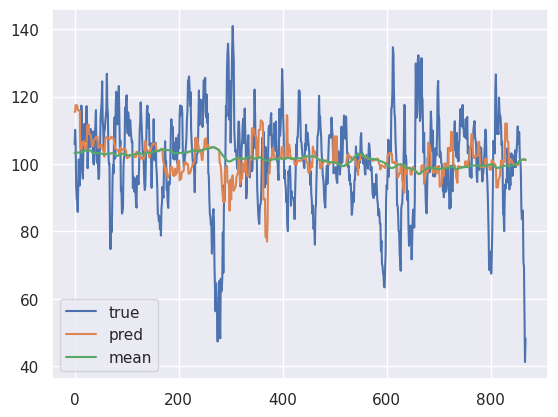

In [22]:
d_var = 'FutRet'
res_directory = glob(f'res_Forward_Lasso/*cvs:3_rolling:True*/{d_var}.pt')
assert len(res_directory) == 1
res = torch.load(res_directory[0])
true_arr = np.array([dic['true'] for dic in res.values()])
pred_arr = np.array([dic['pred'] for dic in res.values()])
trend_arr = np.array([dic['mean'] for dic in res.values()])
df_arr = pd.DataFrame([true_arr, pred_arr, trend_arr], index=['true','pred','mean']).T
df_arr = df_arr.dropna().astype(float)
df_arr.plot()

In [31]:
sum(np.sign(true_arr - 100) == np.sign(pred_arr - 100)) / len(true_arr)

0.4771689497716895

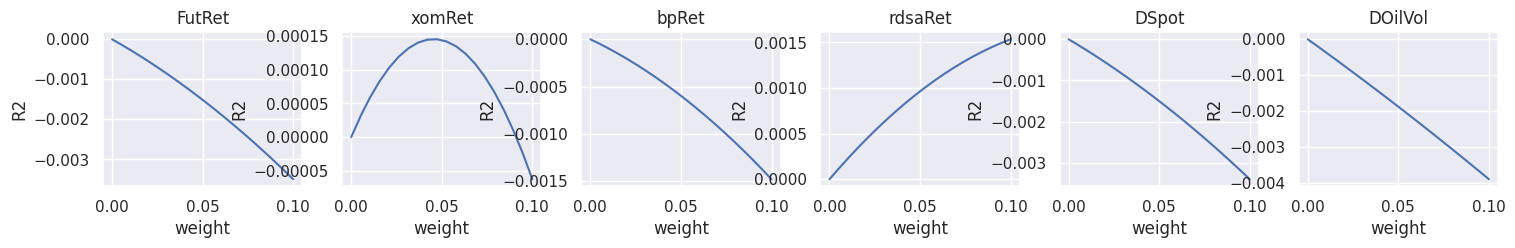

In [7]:
# using v19.2_mod
plot_blends('cvs:3_rolling:False', wt_max=0.1)

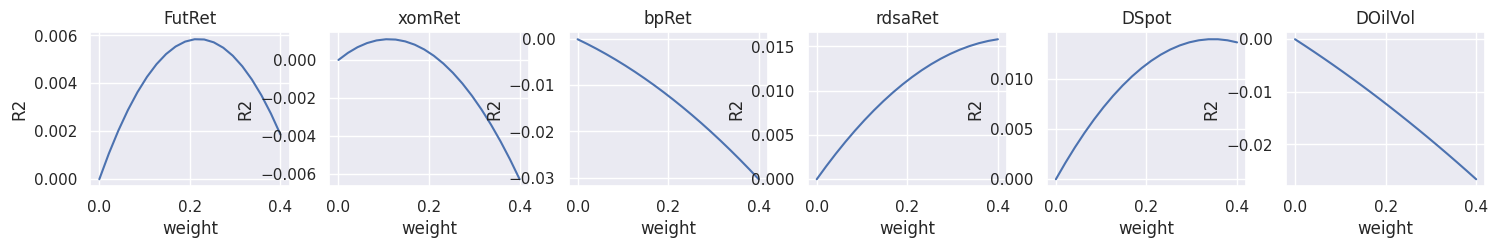

In [17]:
# using v18
plot_blends('cvs:3_rolling:False', wt_max=0.4)

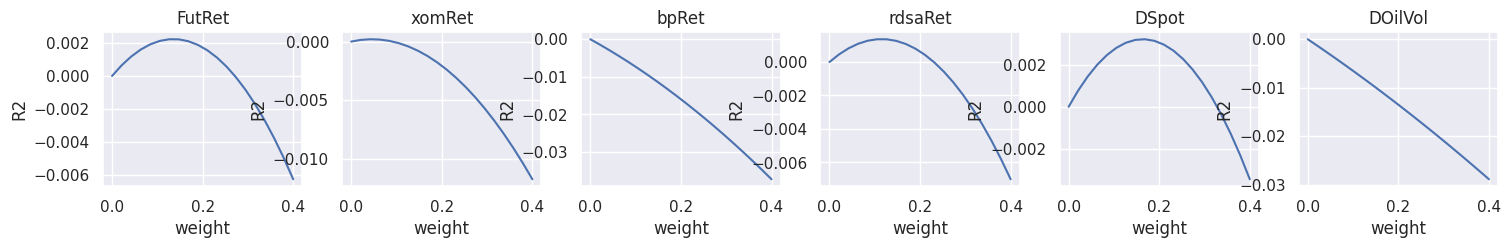

In [20]:
# using v19.2_acc
plot_blends('cvs:3_rolling:False', wt_max=0.4)

### 2/2/24

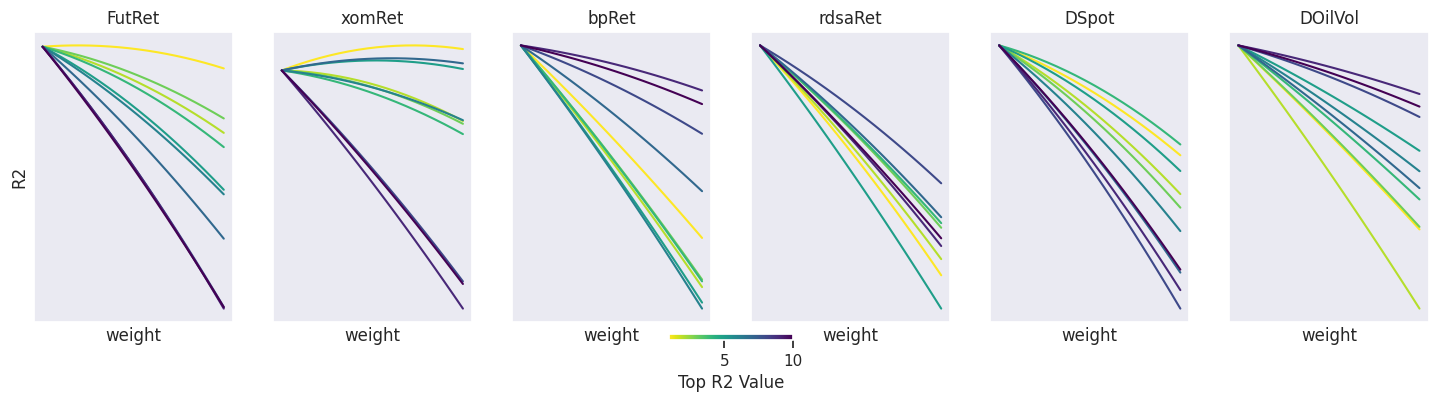

In [2]:
import matplotlib as mpl
cmap = plt.cm.viridis_r
norm = mpl.colors.Normalize(vmin=1, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol']
wt_max = 0.1


fig, ax = plt.subplots(figsize=(18,4), ncols=len(d_var_list))
for top_R2 in range(1,11):
    res_dir_filter = f'cvs:3_rolling:True*top_R2:{top_R2}_'

    R2 = {}

    for d_var in d_var_list:
        res_directory = glob(f'res_Forward_Lasso/*{res_dir_filter}*/{d_var}.pt')
        if res_directory:
            assert len(res_directory) == 1
            res = torch.load(res_directory[0])
            true_arr = np.array([dic['true'] for dic in res.values()])
            pred_arr = np.array([dic['pred'] for dic in res.values()])
            trend_arr = np.array([dic['mean'] for dic in res.values()])

            R2[d_var] = []
            wt_list = np.linspace(0,wt_max,20)
            for wt in wt_list:
                pred_w = wt*pred_arr + (1-wt)*trend_arr
                R2[d_var].append(get_R2(true_arr, pred_w, trend_arr))

    for i, d_var in enumerate(d_var_list):
        color = cmap(norm(top_R2))
        if d_var in R2.keys():
            ax[i].plot(wt_list, R2[d_var], color=color)
        ax[i].set_title(d_var)
        if i == 0:
            ax[i].set_ylabel('R2')
        ax[i].set_xlabel('weight')
        ax[i].set_yticks([])
        ax[i].set_xticks([])

fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='horizontal', fraction=0.02, pad=0.04, label='Top R2 Value');

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


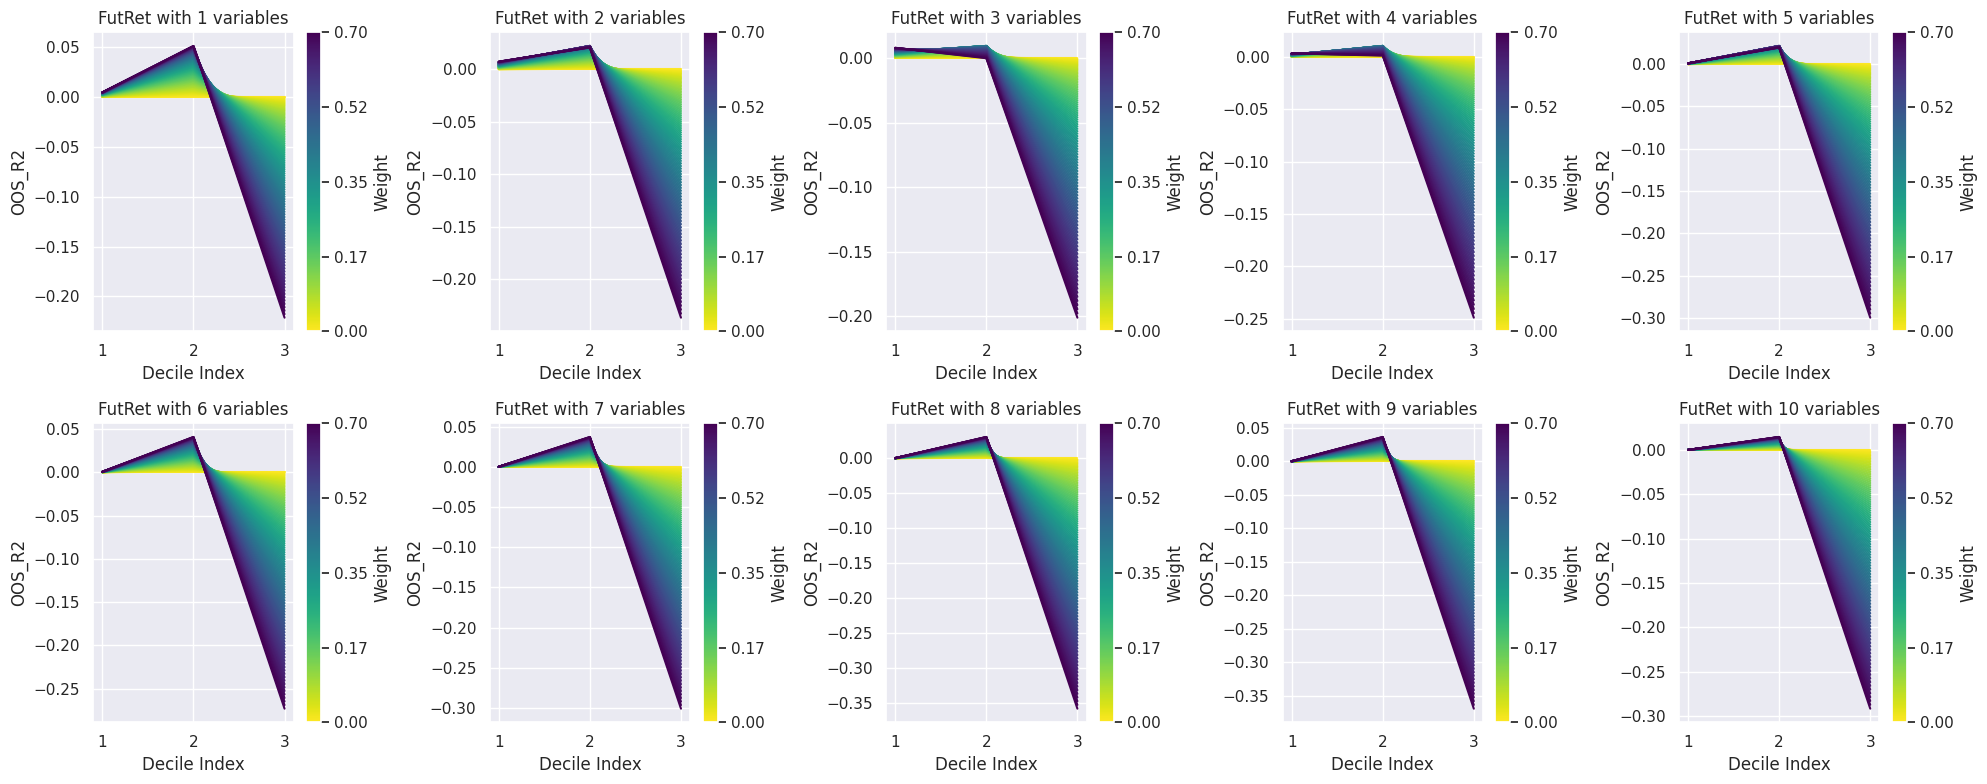

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


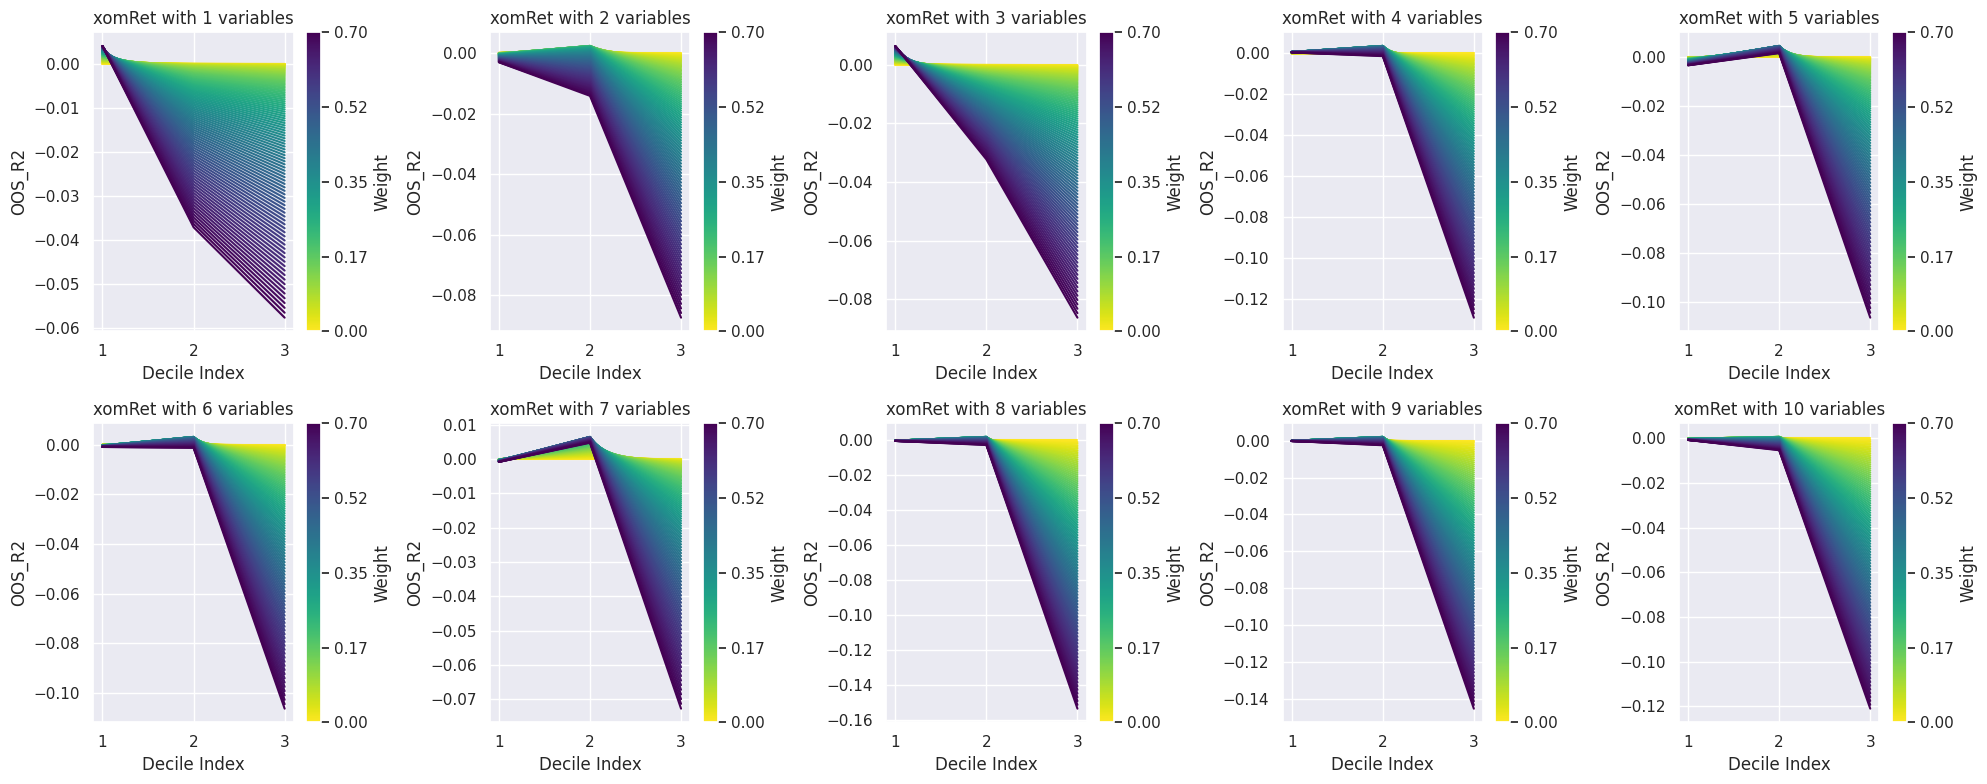

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


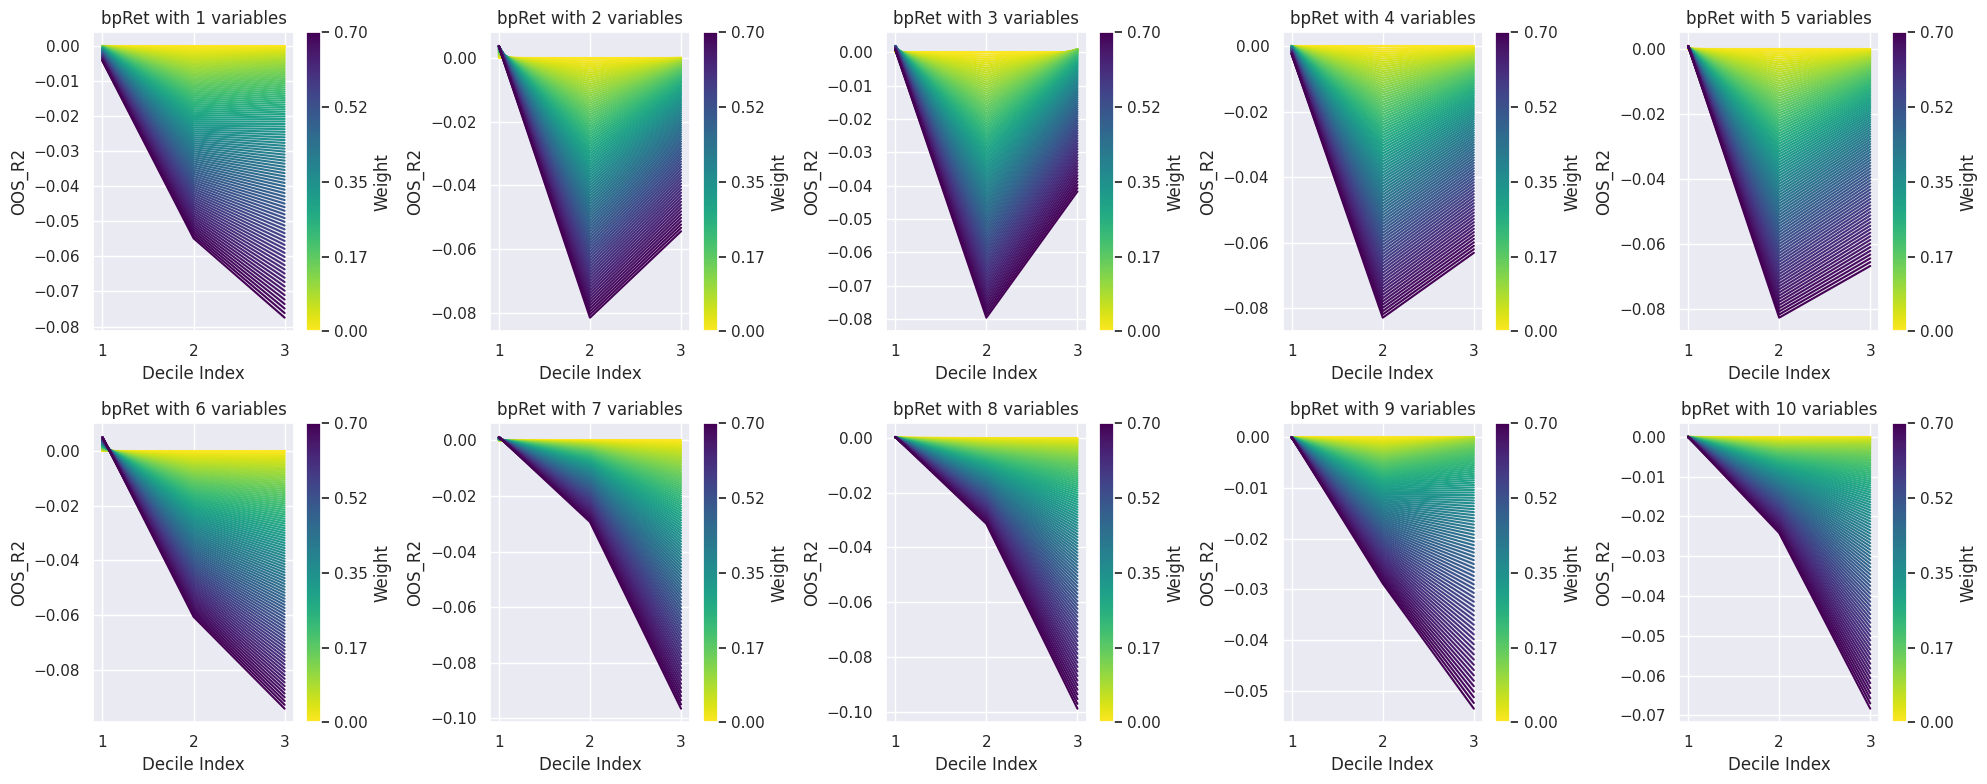

 50%|██████████████████████                      | 5/10 [00:05<00:05,  1.08s/it]

No files matched


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


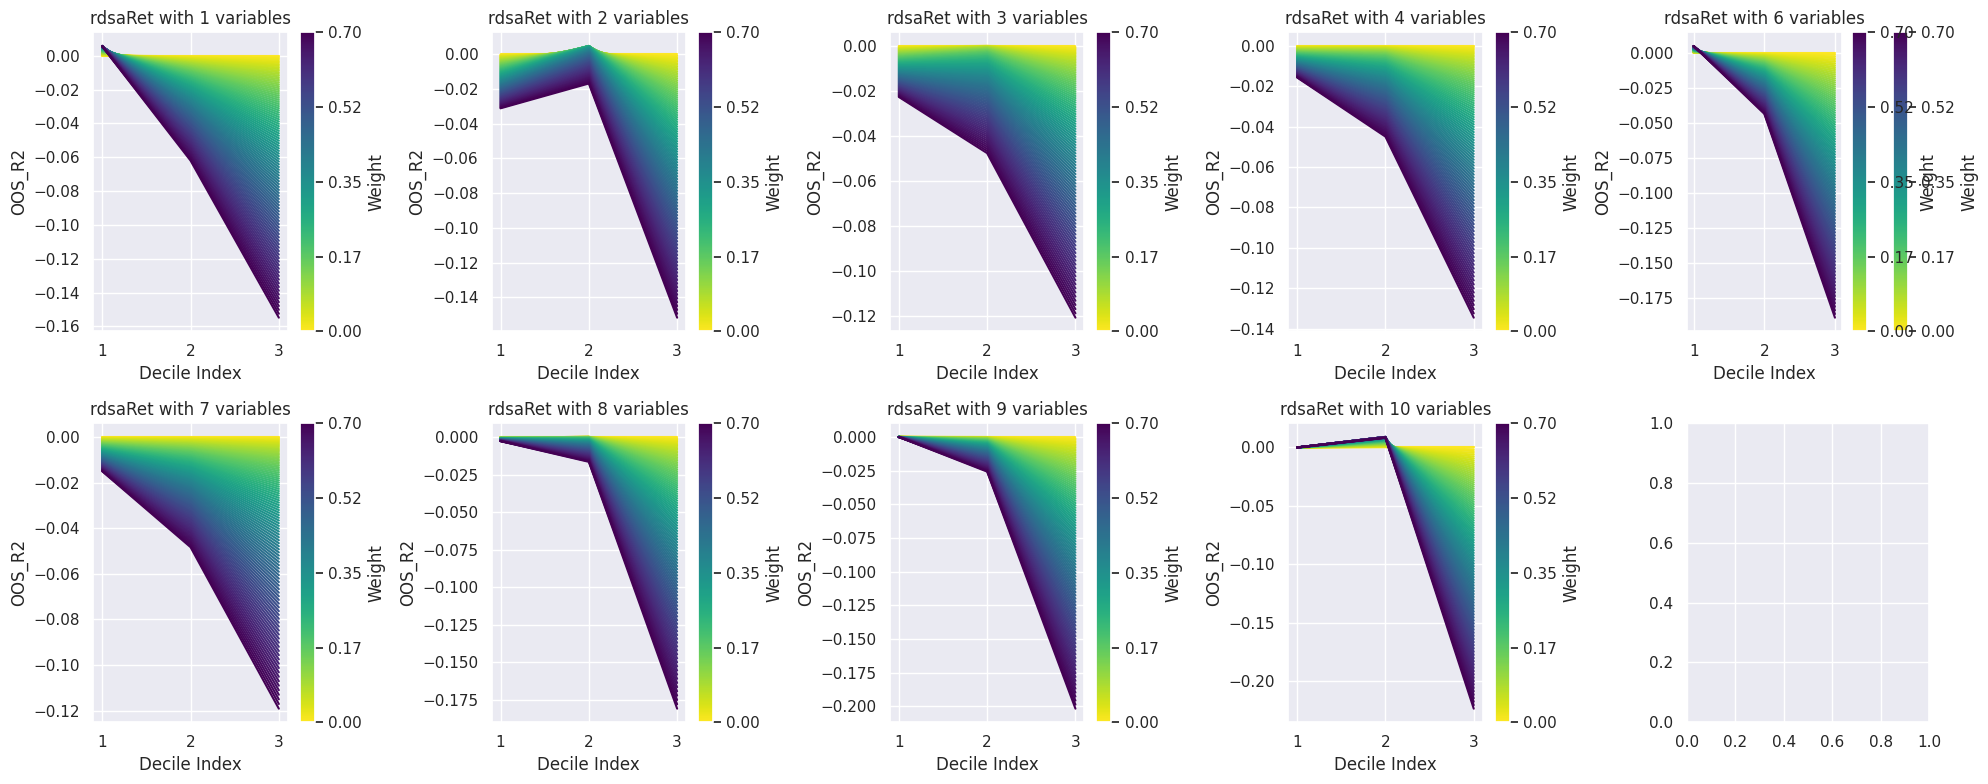

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


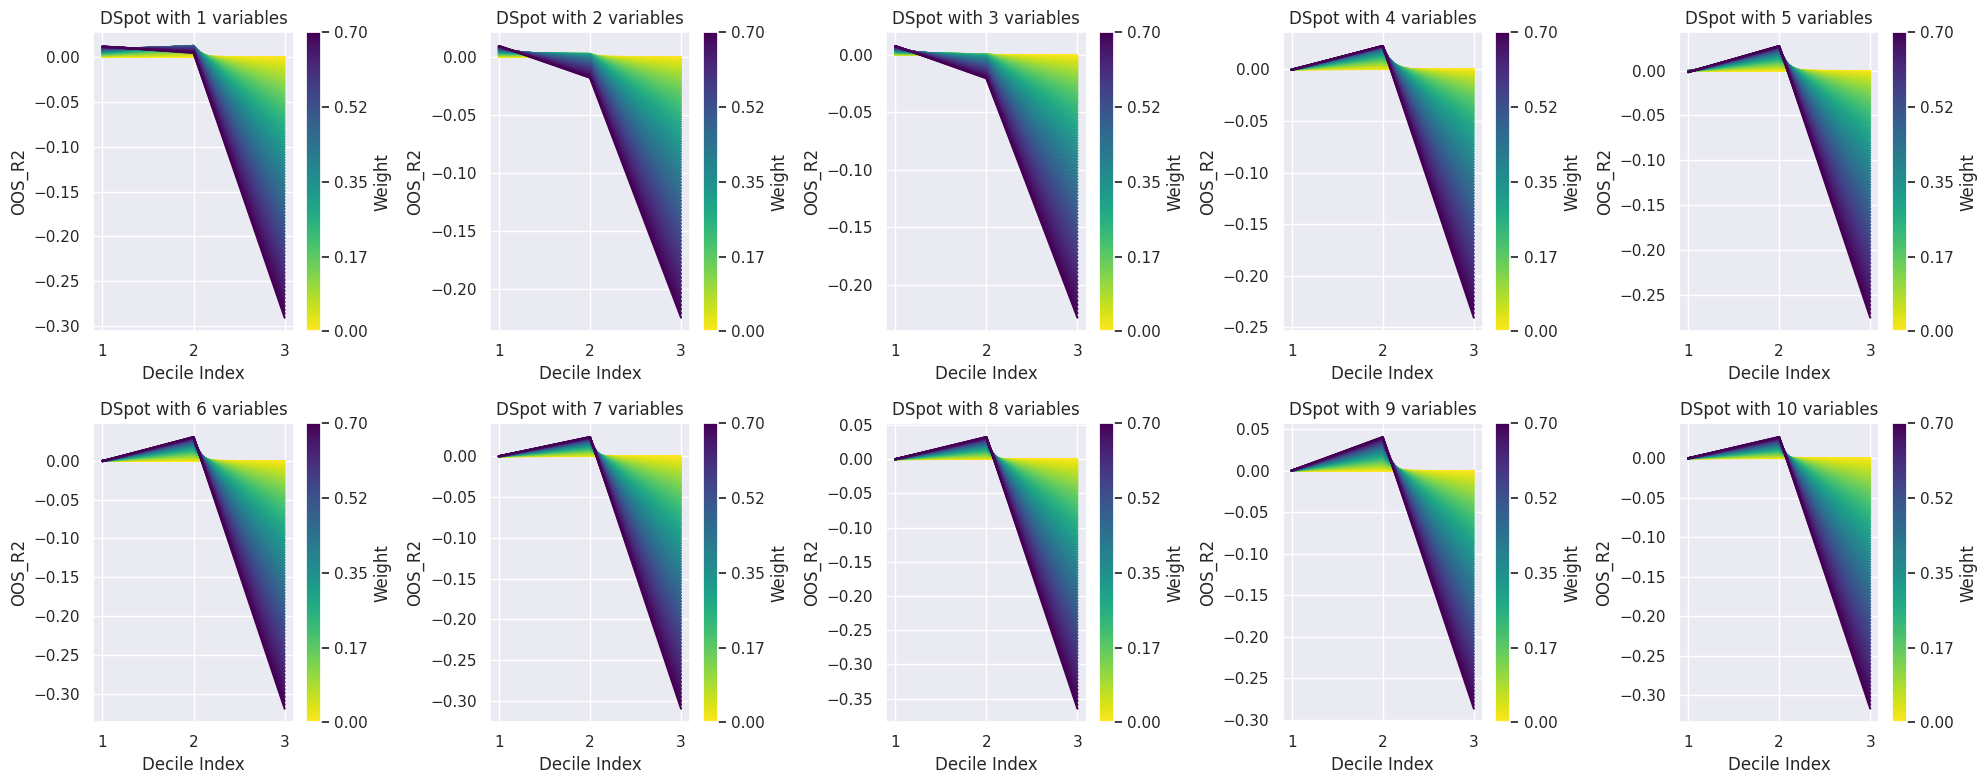

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


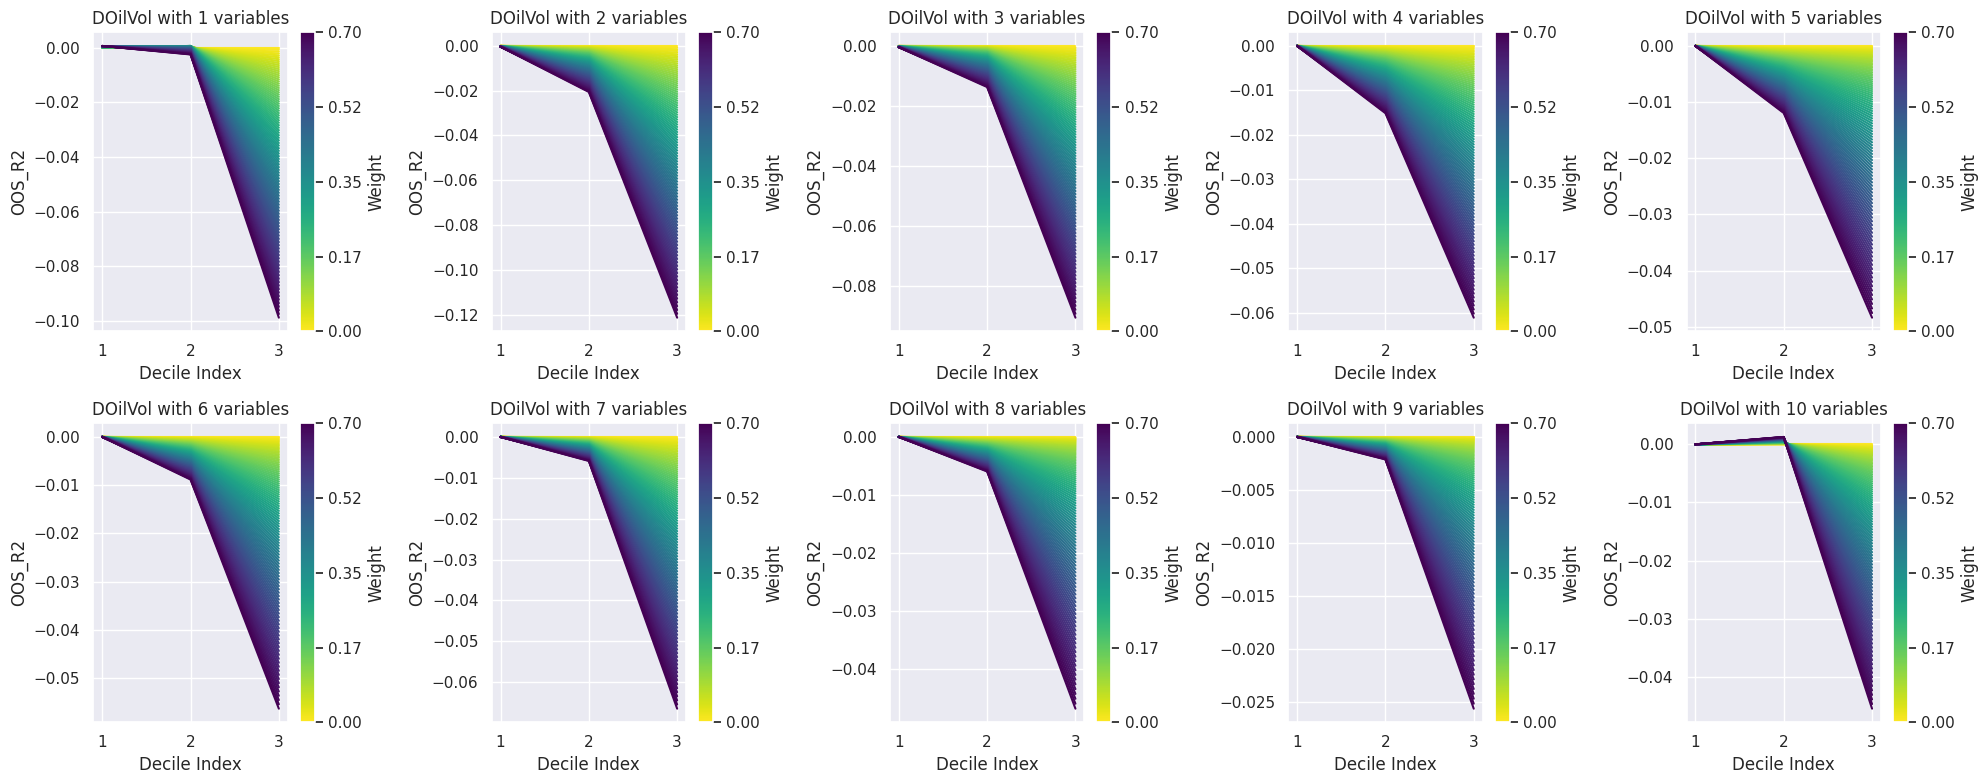

In [17]:
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

num_buckets = 3
for d_var in ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol']:
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    wt_max = 0.7
    wt_list = np.linspace(0, wt_max, 100)
    colors = cm.viridis_r(wt_list / wt_max)

    plot_count = 0
    for top_R2 in tqdm(range(1,11)):
        res = load_res(top_R2, d_var)
        if res:
            sorted_keys = sorted(res, key=lambda x: res[x]['in_sample_R2'])
            decile_indices = np.linspace(0, len(sorted_keys), num_buckets+1, dtype=int)

            deciles = {}

            ax = axs[plot_count // 5, plot_count % 5]
            plot_count += 1

            # Create arrays for each decile
            for i in range(num_buckets):
                keys = sorted_keys[decile_indices[i]:decile_indices[i+1]]
                deciles[i] = {
                    'pred': np.array([res[k]['pred'] for k in keys]),
                    'true': np.array([res[k]['true'] for k in keys]),
                    'mean': np.array([res[k]['mean'] for k in keys]),
                }

            for i, wt in enumerate(wt_list):
                oos_r2_values = []
                for decile in deciles.values():
                    pred_w = wt * decile['pred'] + (1 - wt) * decile['mean']
                    oos_r2 = get_R2(decile['true'], pred_w, decile['mean'])
                    oos_r2_values.append(oos_r2)

                #ax.plot(range(1, num_buckets), oos_r2_values[:-1], color=colors[i])
                ax.plot(range(1, num_buckets+1), oos_r2_values, color=colors[i])

        sm = cm.ScalarMappable(cmap=cm.viridis_r)
        cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(0, 1, 5))
        cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(0, wt_max, 5)])
        cbar.set_label('Weight')
        ax.set_xlabel('Decile Index')
        ax.set_ylabel('OOS_R2')
        ax.set_title(f'{d_var} with {top_R2} variables')

    plt.tight_layout()
    plt.show()

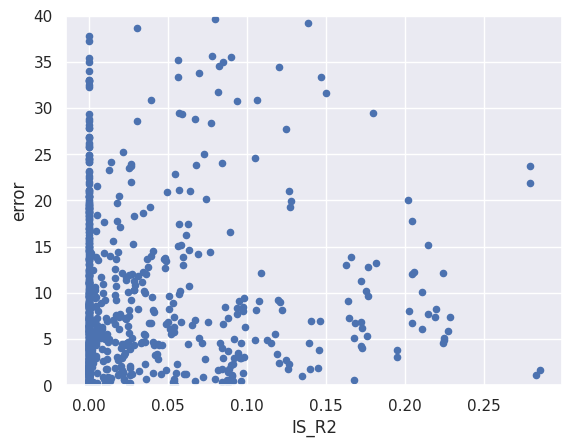

In [55]:
import pandas as pd
df = pd.DataFrame(index=res.keys(), columns=['IS_R2','error'])
for key, value in res.items():
    df.loc[key, 'IS_R2'] = value['in_sample_R2']
    df.loc[key, 'error'] = np.abs(value['pred'] - value['true'])
fig, ax = plt.subplots()
df.plot.scatter('IS_R2','error', ax=ax)
ax.set_ylim(0,40);

In [46]:
df['IS_R2'].iloc[int(len(df)/2):].quantile([0,0.33,0.67])

0.00        -0.0
0.33         0.0
0.67    0.005419
Name: IS_R2, dtype: object

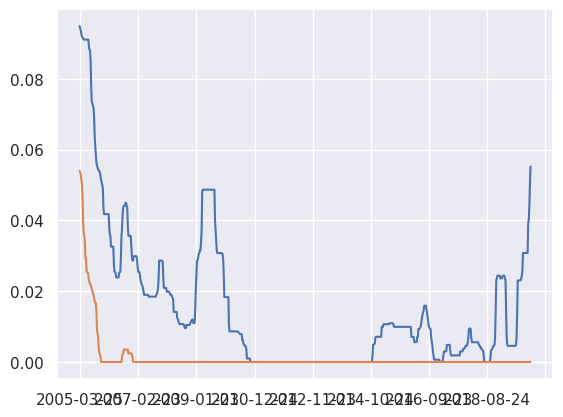

In [56]:
fig, ax = plt.subplots()
df['IS_R2'].rolling(100).quantile(0.67).plot(ax=ax)
df['IS_R2'].rolling(100).quantile(0.33).plot(ax=ax);

### 2/6/24; 2/13/24

#### No negative R2

In [15]:
import sys
sys.argv = ['']
from OOSfuncs import data_set, get_test_row_range, ind_var_list, PCA_augment, standardize, get_end_of_week
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
import statsmodels.api as sm
import statsmodels.regression.linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
seed = 12345
import os
import torch
from tqdm import tqdm

from forward_lasso import *

if __name__ == '__main__':
    
    opt = parse_option()
    print(opt)
    
    directory_name = f"wk:{opt.wk}_window:{opt.window}_frequency:{opt.frequency}_cvs:{opt.cvs}_rolling:{opt.rolling}_select_significant:{opt.select_significant}_top_R2:{opt.top_R2}_normalize:{opt.normalize}"
    directory_path = os.path.join(f'res_{opt.model_name}', directory_name)
    os.makedirs(directory_path, exist_ok=True)
    
    time_col = data_set(opt.d_var)['date'] 
    time_lower = time_col[0]
    # a list of dates
    test_week_list = [time for time in time_col if time>=time_lower+pd.Timedelta(str(7*opt.window*52)+'days')][::opt.frequency]
    if get_end_of_week(opt.d_var) == 'Fri':
        assert test_week_list[0].weekday() == 4, "The dates are not Fridays"
    elif get_end_of_week(opt.d_var) == 'Tue':
        assert test_week_list[0].weekday() == 1, "The dates are not Tuesdays"
    else:
        raise ValueError("The dates are not end of weeks (Tuesdays or Fridays)")
    
    res = {}

    for ii, end_of_train in enumerate(tqdm(test_week_list[23:24])): #[876:]
        try:
            x_train, y_train, x_test, y_test = get_train_test_split(opt, end_of_train)
            
            x_train_normed = standardize(x_train)
            y_train_normed = standardize(y_train)
            x_test_normed = (x_test - x_train.mean())/x_train.std()
            
            model = train_forward_lasso(x_train_normed, y_train_normed, opt)
            significant_ind_vars = list(model.feature_names_in_)
            pred_train_normed = model.predict(x_train_normed[significant_ind_vars])
            pred_test = model.predict(x_test_normed[significant_ind_vars]) * y_train.std() + y_train.mean()
            assert len(pred_test) == len(y_test) == 1, 'Prediction or truth has wrong size'
            
            res[str(end_of_train)[:10]] = {'d_var':opt.d_var,
                                           'best_lambda':model.best_params_['alpha'], 
                                           'significant_ind_vars':significant_ind_vars,
                                            'pred':pred_test[0], 'true':y_test.astype(float).values[0],
                                            'mean':y_train.mean(), 'std':y_train.std(),
                                            'coefs':list(model.best_estimator_.coef_),
                                            'in_sample_R2':r2_score(y_train_normed.values, pred_train_normed)}
            if r2_score(y_train_normed.values, pred_train_normed) <0:
                print(r2_score(y_train_normed.values, pred_train_normed, force_finite=True))
                print(r2_score(y_train_normed.values, pred_train_normed, force_finite=False))
            # generate buckets of IS R2, and compare the OOS R2 for each bucket
            # still need ex-ante rules
        except IndexError:
            break

Namespace(wk=8, window=5, frequency=1, cvs=3, rolling=True, select_significant=True, top_R2=2, normalize=True, model_name='Forward_Lasso', d_var='FutRet')


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]

-2.897292405990015e-09
-2.897292405990015e-09


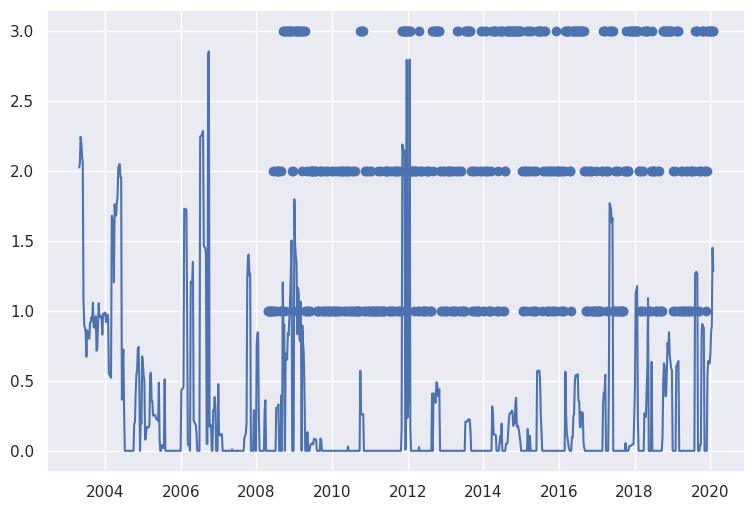

In [77]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df.index, df['in_sample_R2']*10)
ax.scatter(df.index,df['tercile_label']);

### 2/20/24

100%|███████████████████████████████████████████| 10/10 [00:33<00:00,  3.38s/it]


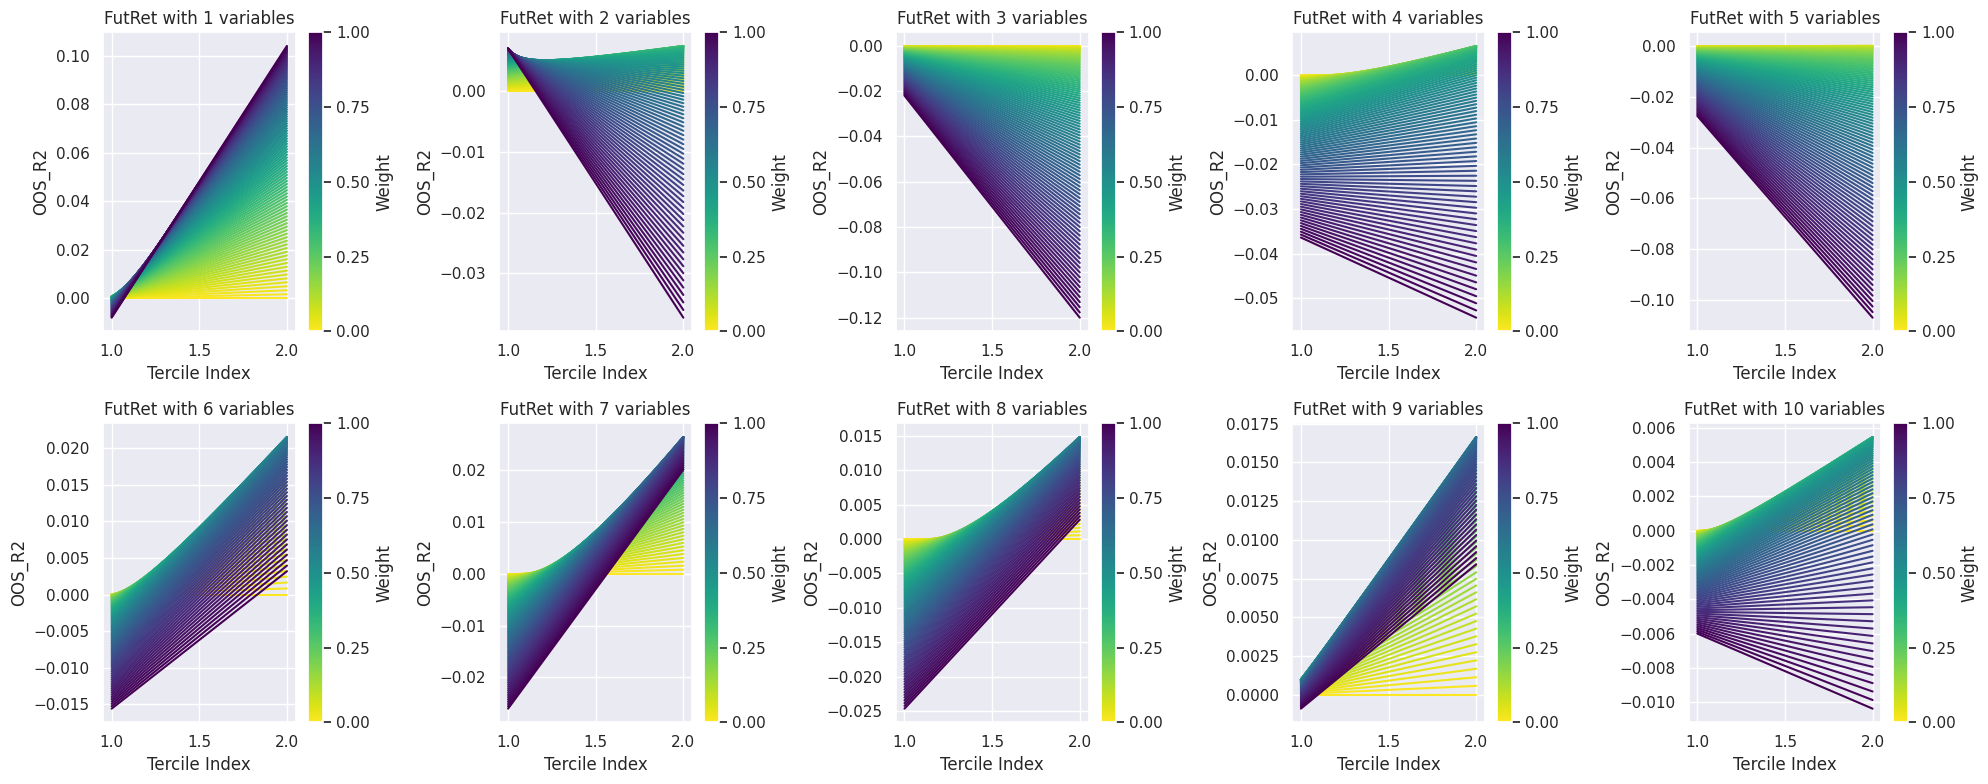

100%|███████████████████████████████████████████| 10/10 [00:36<00:00,  3.62s/it]


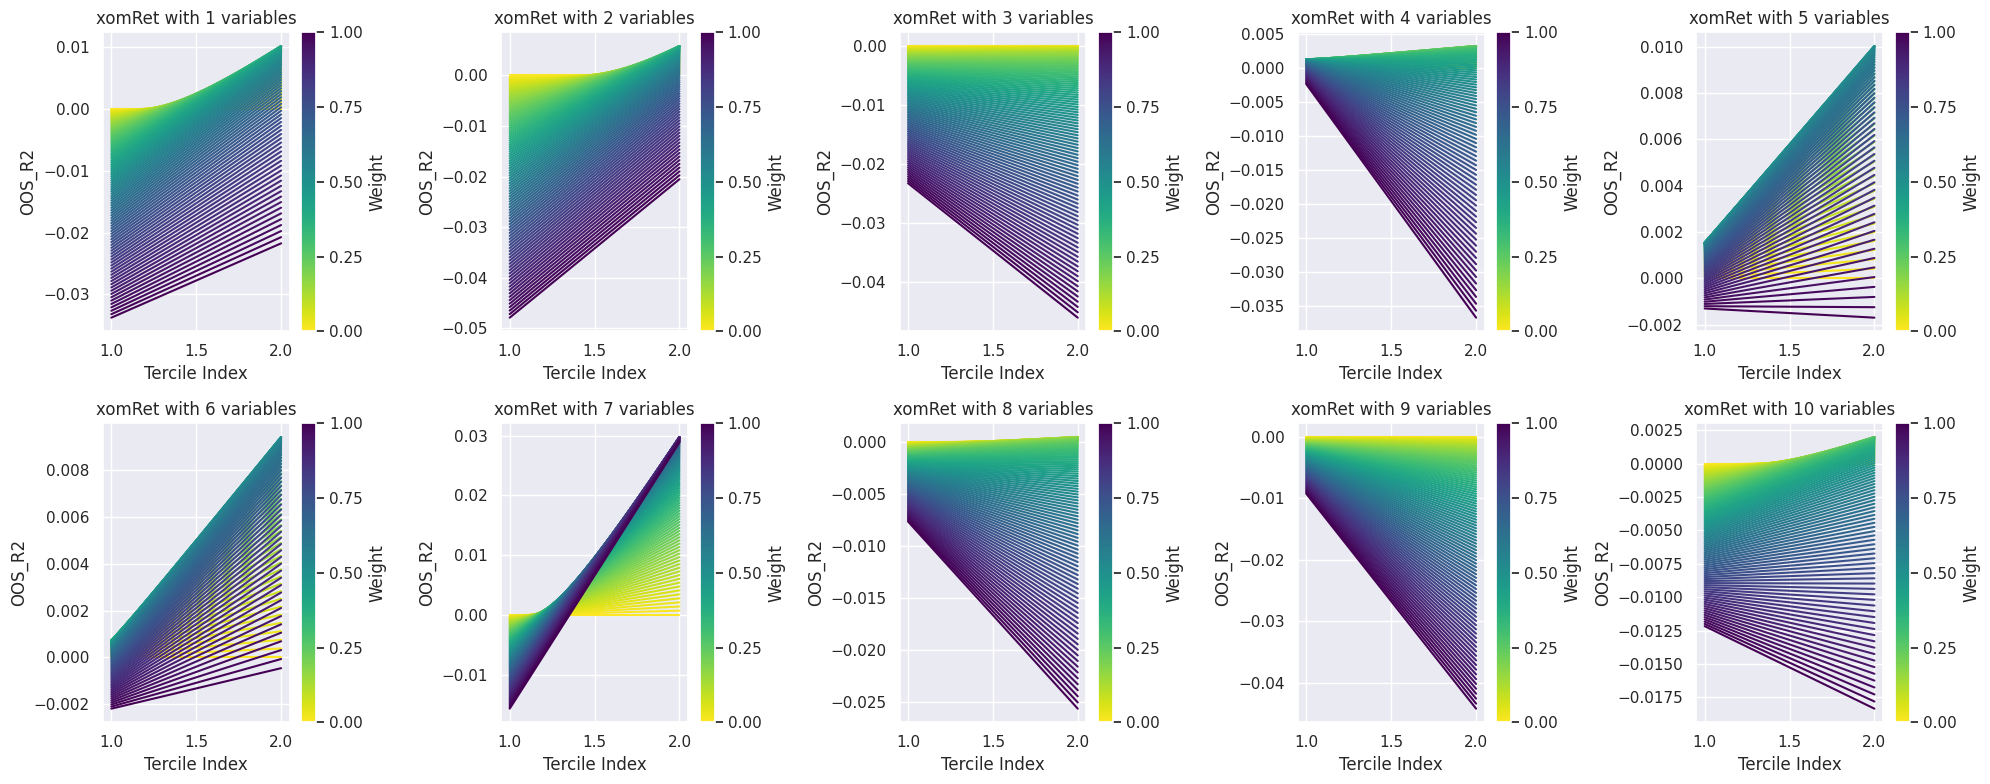

100%|███████████████████████████████████████████| 10/10 [00:35<00:00,  3.55s/it]


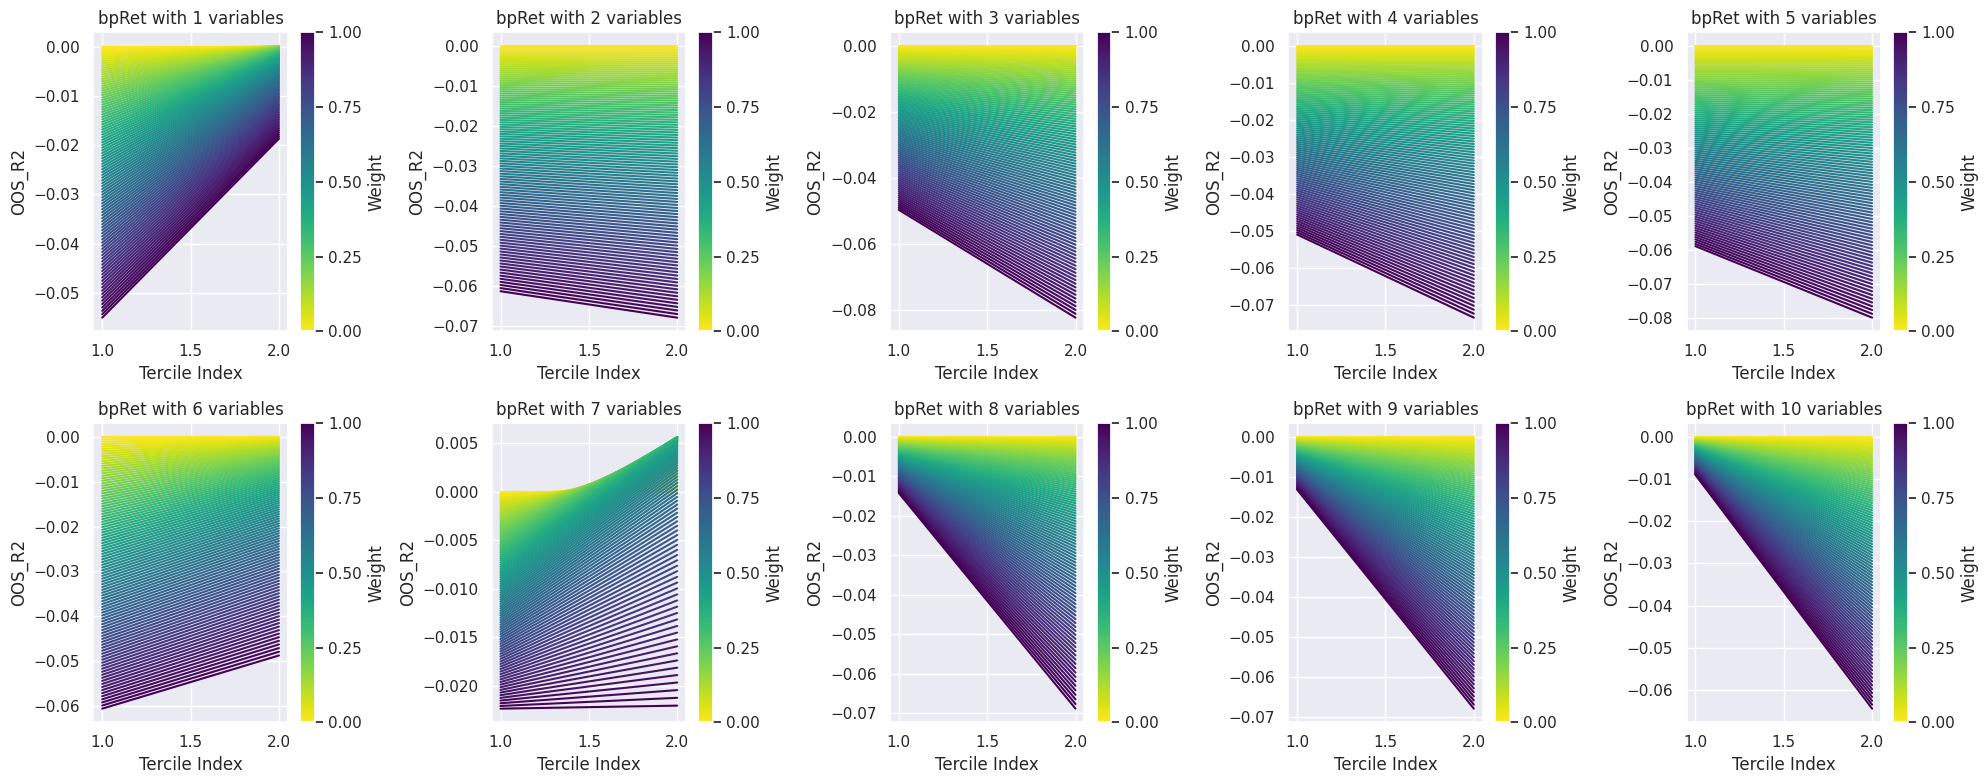

 10%|████▍                                       | 1/10 [00:04<00:37,  4.13s/it]

KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x14f7320d9b80> (for post_execute):



KeyboardInterrupt



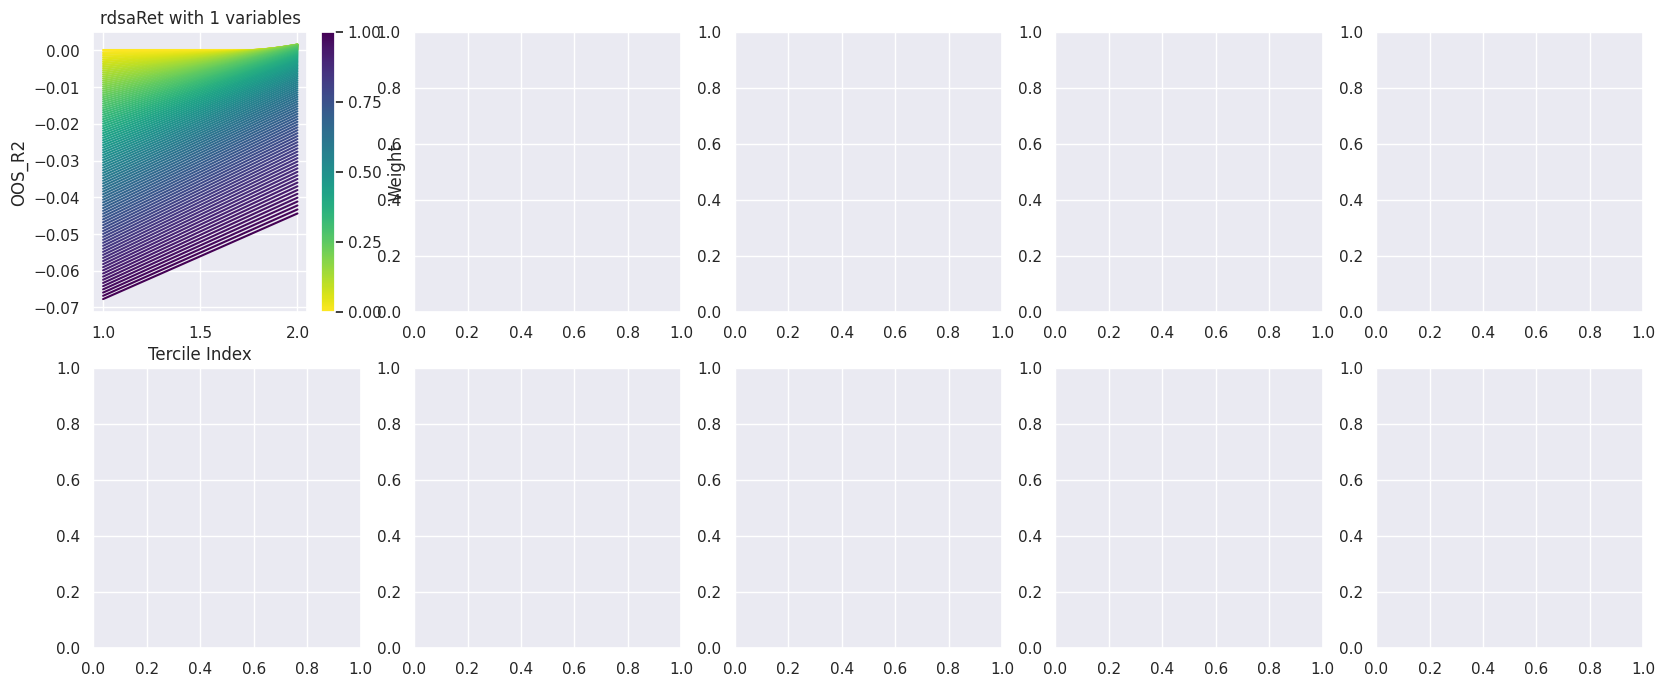

In [11]:
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# OOS R2 by trading only in the mid tercile
df_dic = {}
num_buckets = 3
d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol', 'DInv', 'DProd']
top_R2_range = range(1,11)
for years_look_back in range(3,4):
    df_dic[years_look_back] = pd.DataFrame(index=top_R2_range, columns=d_var_list)
    window_size = f'{365*years_look_back}D'

    for d_var in d_var_list:#['DInv', 'DProd']:
        fig, axs = plt.subplots(2, 5, figsize=(20, 8))
        wt_max = 2
        wt_list = np.linspace(0, wt_max, 100)
        colors = cm.viridis_r(wt_list / wt_max)

        plot_count = 0
        for top_R2 in tqdm(top_R2_range):
            res = load_res(top_R2, d_var)
            if res:
                df = pd.DataFrame(res).T
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()
                #window_size = '1825D'
                #window_size = 261
                df['tercile_label'] = df['in_sample_R2'].rolling(window=window_size, min_periods=3)\
                                                        .apply(compute_tercile_label, raw=False)

                ax = axs[plot_count // 5, plot_count % 5]
                plot_count += 1

                oos_r2_mid_tercile = []
                for i, wt in enumerate(wt_list):
                    oos_r2_values = []
                    for decile_idx in range(1,num_buckets+1):
                        decile = df[df['tercile_label']==decile_idx]
                        pred_w = wt * decile['pred'] + (1 - wt) * decile['mean']
                        oos_r2 = get_R2(decile['true'], pred_w, decile['mean'])
                        oos_r2_values.append(oos_r2)

                    ax.plot(range(1, num_buckets), oos_r2_values[:-1], color=colors[i])
                    #ax.plot(range(1, num_buckets+1), oos_r2_values, color=colors[i])
                    oos_r2_mid_tercile.append(oos_r2_values[1])
                df_dic[years_look_back].loc[top_R2, d_var] = np.max(oos_r2_mid_tercile)

            sm = cm.ScalarMappable(cmap=cm.viridis_r)
            cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(0, 1, 5))
            cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(0, wt_max, 5)])
            cbar.set_label('Weight')
            ax.set_xlabel('Tercile Index')
            ax.set_ylabel('OOS_R2')
            ax.set_title(f'{d_var} with {top_R2} variables')

        plt.tight_layout()
        plt.show()

In [6]:
# OOS R2 by trading only in the mid tercile
from tqdm import tqdm

df_dic = {}
num_buckets = 3
d_var_list = ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol', 'DInv', 'DProd']
top_R2_range = range(1,11)
for years_look_back in [1,3,5]:
    df_dic[years_look_back] = pd.DataFrame(index=top_R2_range, columns=d_var_list)
    window_size = f'{365*years_look_back}D'

    for d_var in tqdm(d_var_list):#['DInv', 'DProd']:
        wt_max = 2
        wt_list = np.linspace(0, wt_max, 100)

        for top_R2 in top_R2_range:
            res = load_res(top_R2, d_var)
            if res:
                df = pd.DataFrame(res).T
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()
                df['tercile_label'] = df['in_sample_R2'].rolling(window=window_size, min_periods=3)\
                                                        .apply(compute_tercile_label, raw=False)


                oos_r2_mid_tercile = []
                for i, wt in enumerate(wt_list):
                    decile_idx = 2
                    decile = df[df['tercile_label']==decile_idx]
                    pred_w = wt * decile['pred'] + (1 - wt) * decile['mean']
                    oos_r2 = get_R2(decile['true'], pred_w, decile['mean'])
                    oos_r2_mid_tercile.append(oos_r2)
                df_dic[years_look_back].loc[top_R2, d_var] = np.max(oos_r2_mid_tercile)
    torch.save(df_dic, 'res_Forward_Lasso_OOS_R2.pt')

100%|█████████████████████████████████████████████| 8/8 [00:48<00:00,  6.03s/it]


In [9]:
df_dic[5]

FutRet    xomRet     bpRet   rdsaRet     DSpot   DOilVol      DInv  \
1   0.082603       0.0       0.0  0.000004  0.008637   0.02299  0.000531   
2        0.0  0.000019  0.012886  0.002871  0.006471       0.0  0.033561   
3   0.002644       0.0       0.0  0.001426       0.0       0.0  0.042375   
4   0.014926       0.0       0.0       0.0  0.013112       0.0  0.010659   
5   0.008854  0.001047       0.0       0.0  0.001554       0.0  0.026859   
6    0.03251    0.0039       0.0       0.0  0.038832       0.0  0.076012   
7   0.023392  0.015469       0.0       0.0  0.012668       0.0  0.061581   
8   0.005558  0.006888       0.0       0.0   0.01295       0.0  0.026878   
9   0.009735  0.004164       0.0       0.0  0.038303       0.0  0.041869   
10  0.017822  0.004155       0.0       0.0  0.025697  0.000006  0.048278   

       DProd  
1   0.013592  
2   0.009836  
3   0.005617  
4   0.011742  
5   0.002779  
6   0.025391  
7   0.001911  
8        0.0  
9        0.0  
10       0.0

### 3/5/24; 3/11/24

In [3]:
res = load_res(1, 0, 'DOilVol')

In [15]:
significant_ind_vars = [i['significant_ind_vars'] for i in res.values()]
dates = res.keys()
pd.Series(np.squeeze(significant_ind_vars), index=dates)

2003-04-25      OilVol
2003-05-02      OilVol
2003-05-09      OilVol
2003-05-16      OilVol
2003-05-23      OilVol
                ...   
2020-01-03    ovx_diff
2020-01-10    ovx_diff
2020-01-17    ovx_diff
2020-01-24        BEME
2020-01-31        BEME
Length: 876, dtype: object

In [3]:
def compute_tercile_label(window):
    if len(window) < 3:  # Not enough data to compute terciles
        return np.nan
    else:
        thresholds = np.quantile(window, [1/3, 2/3])
        if window.iloc[-1] <= thresholds[0]:
            return 1  # First tercile
        elif window.iloc[-1] <= thresholds[1]:
            return 2  # Second tercile
        else:
            return 3  # Third tercile

In [5]:
for num_nontext_var in range(4):
    for num_text_var in tqdm(range(4)):
        if num_nontext_var > 0 or num_text_var > 0:
            for d_var in ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol', 'DInv', 'DProd']:

                res = load_res(num_nontext_var, num_text_var, d_var)
                if res:
                    df = pd.DataFrame(res).T
                    df.index = pd.to_datetime(df.index)
                    df = df.sort_index()

                    for years_look_back in range(1,6):
                        window_size = f'{365*years_look_back}D'
                        df[f'lookback_tercile_lag_{years_look_back}yr'] = df['in_sample_R2'].rolling(window=window_size, min_periods=3)\
                                                                .apply(compute_tercile_label, raw=False)

                    df = df.drop(columns=['d_var','significant_ind_vars','best_lambda','std','coefs','in_sample_R2'])
                    df.to_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}.csv")

100%|█████████████████████████████████████████████| 4/4 [00:23<00:00,  5.75s/it]


#### first half and second half; non-integer lookback

In [8]:
for num_nontext_var, num_text_var in zip([0,1,1], [1,0,1]):
    if num_nontext_var > 0 or num_text_var > 0:
        for d_var in ['FutRet', 'xomRet', 'bpRet', 'rdsaRet', 'DSpot', 'DOilVol', 'DInv', 'DProd']:

            res = load_res(num_nontext_var, num_text_var, d_var)
            if res:
                df = pd.DataFrame(res).T
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                for years_look_back in np.linspace(1,5,9):
                    window_size = f'{int(365*years_look_back)}D'
                    df[f'lookback_tercile_lag_{years_look_back}yr'] = df['in_sample_R2'].rolling(window=window_size, min_periods=3)\
                                                            .apply(compute_tercile_label, raw=False)

                df = df.drop(columns=['d_var','significant_ind_vars','best_lambda','std','coefs','in_sample_R2'])
                df = df.sort_index().dropna()
                df.to_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}.csv")
#                 df.iloc[:int(len(df)*0.7)].to_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}_first_half.csv")
#                 df.iloc[int(len(df)*0.7):].to_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}_second_half.csv")
                

### 3/19/24; 3/25/24; 4/1/24

In [2]:
d_var_list = ['FutRet', 'DSpot', 'DOilVol', 'xomRet', 'bpRet', 'rdsaRet', 'DInv', 'DProd']
wt_max = 1

def get_R2_from_df(df_arr, wt, adjusted_var):
    pred_w = wt * df_arr['pred'] + (1 - wt) * df_arr['mean']
    num = (df_arr['true'] - pred_w).var()
    return 1-num/adjusted_var

def get_R2_from_df_updated(df_arr, wt, adjusted_var):
    pred_w = wt * df_arr['pred'] + (1 - wt) * df_arr['mean']
    num = ((df_arr['true'] - pred_w)**2).mean()
    return 1-num/adjusted_var

def truncate_negative(arr, threshold=-0.05):
    arr = np.fmax(oos_r2_mid_tercile, threshold)
    arr[np.where(arr==threshold)] = np.nan
    return arr

In [1]:
for tag in ['_first_half', '_second_half', '']:
    df_OOS = pd.DataFrame(columns=np.linspace(1,5,9), index=d_var_list)
    # for years_look_back in tqdm(range(1,6)):
    for years_look_back in tqdm(df_OOS.columns):
        nrows = 3
        fig, ax = plt.subplots(figsize=(4*nrows, 18), nrows=len(d_var_list), ncols=nrows)

        #for num_nontext_var, num_text_var in zip([0,1,1,0,2,2], [1,0,1,2,0,2]):
        for j, d_var in enumerate(d_var_list):
            three_model_OOS = []
            for i, (num_nontext_var, num_text_var) in enumerate(zip([0,1,1], [1,0,1])):

                try:
                    df = pd.read_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}{tag}.csv")
                    legend = []
                    temp = []
                    for tercile_index, linestyle in zip([1,2,3], ['--','-',':']):
                        tercile = df[df[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
                        tercile = tercile[['pred','true','mean']].dropna()
                        adjusted_var = (tercile['true'] - tercile['mean']).var()
                        wt_list = np.linspace(0, wt_max, 100)
                        oos_r2_mid_tercile = []
                        for wt in wt_list:
                            oos_r2 = get_R2_from_df(tercile, wt, adjusted_var)
                            oos_r2_mid_tercile.append(oos_r2)
                        oos_r2_mid_tercile = np.array(oos_r2_mid_tercile)
                        oos_r2_mid_tercile_truncated = truncate_negative(oos_r2_mid_tercile)
                        ax[j,i].plot(wt_list, oos_r2_mid_tercile_truncated*100, linestyle)
                        oos_max = np.nanmax(oos_r2_mid_tercile)
                        temp.append(oos_max*100)
                        legend.append(f"{tercile_index}: {oos_max*100:.1f} ({wt_list[np.argmax(oos_r2_mid_tercile)]:.2f}); \
    {np.nanmin(oos_r2_mid_tercile)*100:.1f} ({wt_list[np.argmin(oos_r2_mid_tercile)]:.2f})")
                    ax[j,i].legend(legend, loc='lower right', fontsize=7)
                    if i == 0:
                        ax[j,i].set_ylabel(d_var, rotation=0, labelpad=20)
                    if j == 0:
                        ax[j,i].set_title(f"nt {num_nontext_var} - t {num_text_var}")

                except FileNotFoundError:
                    pass
                three_model_OOS.append(np.max(temp))
            df_OOS.loc[d_var, years_look_back] = three_model_OOS

        fig.tight_layout()
        #fig.savefig(f'res_Forward_Lasso_lookback_tercile_lag_{years_look_back}yr{tag}.pdf');
    df_OOS.to_csv(f'max_R2{tag}.csv')

NameError: name 'pd' is not defined

### 4/8/24

In [5]:
d_var_list = ['FutRet']
wt_max = 1

nrows = 3
fig, ax = plt.subplots(figsize=(4*nrows, 6), nrows=3, ncols=nrows)

j = -1
for years_look_back in tqdm([2.5,3.0]):
    

    #for num_nontext_var, num_text_var in zip([0,1,1,0,2,2], [1,0,1,2,0,2]):
    for j, d_var in enumerate(d_var_list):
        three_model_OOS = []
        for tag in ['_first_half', '_second_half', '']:
            i = -1
            for num_nontext_var, num_text_var in zip([0,1,1], [1,0,1]):
                    i += 1

                    try:
                        df = pd.read_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}{tag}.csv")
                        legend = []
                        for tercile_index, linestyle in zip([1,2,3], ['--','-',':']):
                            tercile = df[df[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
                            tercile = tercile[['pred','true','mean']].dropna()
                            adjusted_var = (tercile['true'] - tercile['mean']).var()
                            wt_list = np.linspace(0, wt_max, 100)
                            oos_r2_mid_tercile = []
                            for wt in wt_list:
                                oos_r2 = get_R2_from_df(tercile, wt, adjusted_var)
                                oos_r2_mid_tercile.append(oos_r2)
                            oos_r2_mid_tercile = np.array(oos_r2_mid_tercile)
                            oos_r2_mid_tercile_truncated = truncate_negative(oos_r2_mid_tercile)
                            ax[j,i].plot(wt_list, oos_r2_mid_tercile_truncated*100, linestyle)
                            oos_max = np.nanmax(oos_r2_mid_tercile)
                            legend.append(f"{tercile_index}: {oos_max*100:.1f} ({wt_list[np.argmax(oos_r2_mid_tercile)]:.2f}); \
    {np.nanmin(oos_r2_mid_tercile)*100:.1f} ({wt_list[np.argmin(oos_r2_mid_tercile)]:.2f})")
                        #ax[j,i].legend(legend, loc='lower right', fontsize=7)
                        if i == 0:
                            ax[j,i].set_ylabel(d_var, rotation=0, labelpad=20)
                        if j == 0:
                            ax[j,i].set_title(f"nt {num_nontext_var} - t {num_text_var}")

                    except FileNotFoundError:
                        pass
            j += 1
                
    fig.tight_layout()
    #fig.savefig(f'res_Forward_Lasso_lookback_tercile_lag_{years_look_back}yr{tag}.pdf');

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Error in callback <function flush_figures at 0x14ad6f171700> (for post_execute):



KeyboardInterrupt



### 4/15/24; 4/25/24

In [4]:
wt_list = np.linspace(0, wt_max, 101)

for d_var in tqdm(d_var_list):
    for num_nontext_var, num_text_var in zip([0,1,1], [1,0,1]):
        in_sample_best = {}

        df = pd.read_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}.csv", index_col=0)
        df.index = pd.to_datetime(df.index)
        for cutoff_year in range(2007, 2019):
            in_sample_best[cutoff_year] = {}

            cutoff_date_start_of_test = pd.Timestamp(f'{cutoff_year}-01-01')
            cutoff_date_end_of_train = cutoff_date_start_of_test - pd.DateOffset(weeks=8)
            df_first_part = df[df.index <= cutoff_date_end_of_train]

            for years_look_back in np.linspace(1,5,9):
                in_sample_best[cutoff_year][years_look_back] = {}
                for tercile_index in range(1,4):
                    tercile = df_first_part[df_first_part[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
                    tercile = tercile[['pred','true','mean']]
                    #adjusted_var = (tercile['true'] - tercile['mean']).var()
                    adjusted_var = ((tercile['true'] - tercile['mean'])**2).mean()

#                     in_sample_r2_tercile = np.array([get_R2_from_df(tercile, wt, adjusted_var) for wt in wt_list])
                    in_sample_r2_tercile = np.array([get_R2_from_df_updated(tercile, wt, adjusted_var) for wt in wt_list])
                    
                    in_sample_best[cutoff_year][years_look_back][tercile_index] = in_sample_r2_tercile
                    torch.save(in_sample_best, f"res_Forward_Lasso/in_sample_updated_{num_nontext_var}-{num_text_var}_{d_var}.pt")

100%|█████████████████████████████████████████████| 8/8 [07:14<00:00, 54.28s/it]


In [4]:
wt_list = np.linspace(0, wt_max, 101)

for d_var in tqdm(d_var_list):
    for num_nontext_var, num_text_var in zip([0,1,1], [1,0,1]):
        out_of_sample_best = {}

        df = pd.read_csv(f"res_Forward_Lasso/{num_nontext_var}-{num_text_var}_{d_var}.csv", index_col=0)
        df.index = pd.to_datetime(df.index)
        for cutoff_year in range(2007, 2019):
            out_of_sample_best[cutoff_year] = {}

            cutoff_date_start_of_test = pd.Timestamp(f'{cutoff_year}-01-01')
            cutoff_date_end_of_train = cutoff_date_start_of_test - pd.DateOffset(weeks=8)
            df_second_part = df[df.index > cutoff_date_end_of_train]

            for years_look_back in np.linspace(1,5,9):
                out_of_sample_best[cutoff_year][years_look_back] = {}
                for tercile_index in range(1,4):
                    tercile = df_second_part[df_second_part[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
                    tercile = tercile[['pred','true','mean']]
                    #adjusted_var = (tercile['true'] - tercile['mean']).var()
                    adjusted_var = ((tercile['true'] - tercile['mean'])**2).mean()

#                     out_of_sample_r2_tercile = np.array([get_R2_from_df(tercile, wt, adjusted_var) for wt in wt_list])
                    out_of_sample_r2_tercile = np.array([get_R2_from_df_updated(tercile, wt, adjusted_var) for wt in wt_list])
                    out_of_sample_best[cutoff_year][years_look_back][tercile_index] = out_of_sample_r2_tercile
                    torch.save(out_of_sample_best, f"res_Forward_Lasso/out_of_sample_updated_{num_nontext_var}-{num_text_var}_{d_var}.pt")

100%|█████████████████████████████████████████████| 8/8 [07:18<00:00, 54.78s/it]


### Understand why r2 may be the same for different cutoffs

In [26]:
def test(df_arr, wt, adjusted_var):
    pred_w = wt * df_arr['pred'] + (1 - wt) * df_arr['mean']
    num = ((df_arr['true'] - pred_w)**2).mean()
    return num

In [35]:
wt_list = np.linspace(0, wt_max, 101)

d_var = 'FutRet'
df = pd.read_csv(f"res_Forward_Lasso/1-1_{d_var}.csv", index_col=0)
df.index = pd.to_datetime(df.index)
cutoff_year = 2012
cutoff_date_start_of_test = pd.Timestamp(f'{cutoff_year}-01-01')
cutoff_date_end_of_train = cutoff_date_start_of_test - pd.DateOffset(weeks=8)
df_first_part = df[df.index <= cutoff_date_end_of_train]

years_look_back = 1.5
tercile_index = 1
tercile = df_first_part[df_first_part[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
tercile = tercile[['pred','true','mean']]
display(df_first_part)
#adjusted_var = (tercile['true'] - tercile['mean']).var()
adjusted_var = ((tercile['true'] - tercile['mean'])**2).mean()
print(adjusted_var)
print(test(tercile, 0.2, adjusted_var))

pred        true        mean  lookback_tercile_lag_1.0yr  \
2003-05-09  107.603419  106.104164  103.425705                         3.0   
2003-05-16  107.699150  106.104164  103.447040                         2.0   
2003-05-23  107.855026  106.104164  103.485330                         2.0   
2003-05-30  107.916317  106.104164  103.467995                         2.0   
2003-06-06  111.232320   85.800591  103.386240                         1.0   
...                ...         ...         ...                         ...   
2011-10-07  101.759898   99.007050  102.320110                         3.0   
2011-10-14  101.852998   99.007050  102.367510                         3.0   
2011-10-21  101.879181   99.007050  102.385420                         3.0   
2011-10-28   98.868604   99.007050  102.402070                         3.0   
2011-11-04   99.118301   99.007050  102.419860                         3.0   

            lookback_tercile_lag_1.5yr  lookback_tercile_lag_2.0yr  \
2003-05-09                         3.0                         3.0   
2003-05-16                         2.0                         2.0   
2003-05-23                         2.0                         2.0   
2003-05-30                         2.0                         2.0   
2003-06-06                         1.0                         1.0   
...                                ...                         ...   
2011-10-07                         3.0                         3.0   
2011-10-14                         3.0                         3.0   
2011-10-21                         3.0                         3.0   
2011-10-28                         3.0                         3.0   
2011-11-04                         3.0                         3.0   

            lookback_tercile_lag_2.5yr  lookback_tercile_lag_3.0yr  \
2003-05-09                         3.0                         3.0   
2003-05-16                         2.0                         2.0   
2003-05-23                         2.0                         2.0   
2003-05-30                         2.0                         2.0   
2003-06-06                         1.0                         1.0   
...                                ...                         ...   
2011-10-07                         3.0                         3.0   
2011-10-14                         3.0                         3.0   
2011-10-21                         3.0                         3.0   
2011-10-28                         3.0                         3.0   
2011-11-04                         3.0                         3.0   

            lookback_tercile_lag_3.5yr  lookback_tercile_lag_4.0yr  \
2003-05-09                         3.0                         3.0   
2003-05-16                         2.0                         2.0   
2003-05-23                         2.0                         2.0   
2003-05-30                         2.0                         2.0   
2003-06-06                         1.0                         1.0   
...                                ...                         ...   
2011-10-07                         3.0                         3.0   
2011-10-14                         3.0                         3.0   
2011-10-21                         3.0                         3.0   
2011-10-28                         3.0                         3.0   
2011-11-04                         3.0                         3.0   

            lookback_tercile_lag_4.5yr  lookback_tercile_lag_5.0yr  
2003-05-09                         3.0                         3.0  
2003-05-16                         2.0                         2.0  
2003-05-23                         2.0                         2.0  
2003-05-30                         2.0                         2.0  
2003-06-06                         1.0                         1.0  
...                                ...                         ...  
2011-10-07                         3.0                         3.0  
2011-1

319.22025994377066
317.1027977843378


pred        true        mean  lookback_tercile_lag_1.0yr  \
2003-05-09  107.603419  106.104164  103.425705                         3.0   
2003-05-16  107.699150  106.104164  103.447040                         2.0   
2003-05-23  107.855026  106.104164  103.485330                         2.0   
2003-05-30  107.916317  106.104164  103.467995                         2.0   
2003-06-06  111.232320   85.800591  103.386240                         1.0   
...                ...         ...         ...                         ...   
2013-10-04   97.275998  105.226799  102.739430                         1.0   
2013-10-11   96.446326  103.118637  103.005440                         3.0   
2013-10-18   96.432329  103.118637  102.974820                         3.0   
2013-10-25   96.697465  103.118637  102.965940                         3.0   
2013-11-01   96.681160  103.118637  103.011170                         3.0   

            lookback_tercile_lag_1.5yr  lookback_tercile_lag_2.0yr  \
2003-05-09                         3.0                         3.0   
2003-05-16                         2.0                         2.0   
2003-05-23                         2.0                         2.0   
2003-05-30                         2.0                         2.0   
2003-06-06                         1.0                         1.0   
...                                ...                         ...   
2013-10-04                         2.0                         2.0   
2013-10-11                         3.0                         3.0   
2013-10-18                         3.0                         3.0   
2013-10-25                         3.0                         3.0   
2013-11-01                         3.0                         3.0   

            lookback_tercile_lag_2.5yr  lookback_tercile_lag_3.0yr  \
2003-05-09                         3.0                         3.0   
2003-05-16                         2.0                         2.0   
2003-05-23                         2.0                         2.0   
2003-05-30                         2.0                         2.0   
2003-06-06                         1.0                         1.0   
...                                ...                         ...   
2013-10-04                         2.0                         2.0   
2013-10-11                         3.0                         3.0   
2013-10-18                         3.0                         3.0   
2013-10-25                         3.0                         3.0   
2013-11-01                         3.0                         3.0   

            lookback_tercile_lag_3.5yr  lookback_tercile_lag_4.0yr  \
2003-05-09                         3.0                         3.0   
2003-05-16                         2.0                         2.0   
2003-05-23                         2.0                         2.0   
2003-05-30                         2.0                         2.0   
2003-06-06                         1.0                         1.0   
...                                ...                         ...   
2013-10-04                         3.0                         3.0   
2013-10-11                         3.0                         3.0   
2013-10-18                         3.0                         3.0   
2013-10-25                         3.0                         3.0   
2013-11-01                         3.0                         3.0   

            lookback_tercile_lag_4.5yr  lookback_tercile_lag_5.0yr  
2003-05-09                         3.0                         3.0  
2003-05-16                         2.0                         2.0  
2003-05-23                         2.0                         2.0  
2003-05-30                         2.0                         2.0  
2003-06-06                         1.0                         1.0  
...                                ...                         ...  
2013-10-04                         3.0                         3.0  
2013-1

319.22025994377066
317.1027977843378


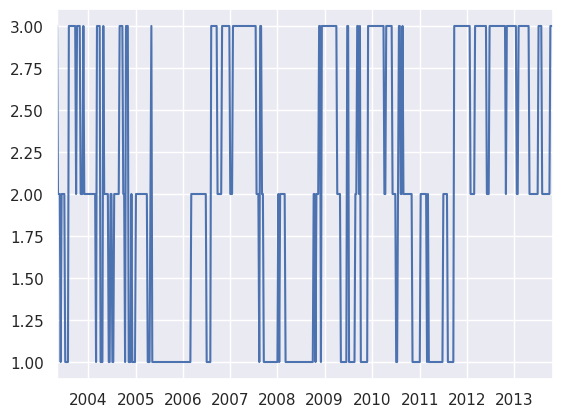

In [37]:
wt_list = np.linspace(0, wt_max, 101)

d_var = 'FutRet'
df = pd.read_csv(f"res_Forward_Lasso/1-1_{d_var}.csv", index_col=0)
df.index = pd.to_datetime(df.index)
cutoff_year = 2014
cutoff_date_start_of_test = pd.Timestamp(f'{cutoff_year}-01-01')
cutoff_date_end_of_train = cutoff_date_start_of_test - pd.DateOffset(weeks=8)
df_first_part = df[df.index <= cutoff_date_end_of_train]

years_look_back = 1.5
tercile_index = 1
tercile = df_first_part[df_first_part[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
tercile = tercile[['pred','true','mean']]
display(df_first_part)
df_first_part[f'lookback_tercile_lag_{years_look_back}yr'].plot()
#adjusted_var = (tercile['true'] - tercile['mean']).var()
adjusted_var = ((tercile['true'] - tercile['mean'])**2).mean()
print(adjusted_var)
print(test(tercile, 0.2, adjusted_var))

In [14]:
df.values.flatten()[-1].replace('nan','0.0')

'[0.18061100393893526, 0, 14.150820210437976]'

In [15]:
latex_output_list = []

for tag, caption in zip(['_first_half', '_second_half', ''], ["first","second","full"]):

    df = pd.read_csv(f'max_R2{tag}.csv', index_col=0)
    #display(df)
    arr = np.reshape([eval(i.replace('nan','0.0')) for i in df.values.flatten()], (8, 9, 3)).transpose(0,2,1)
    bold_numbers = arr.max(axis=1).round(4).flatten()
    reshaped_array = arr.reshape(8*3, 9)#.round(4)
    superindex = ['FutRet', 'DSpot', 'DOilVol', 'xomRet', 'bpRet', 'rdsaRet', 'DInv', 'DProd']
    subindex = ['text', 'nontext', 'both']
    multi_index = pd.MultiIndex.from_product([superindex, subindex], names=['', ''])
    df = pd.DataFrame(reshaped_array, index=multi_index)
    df.columns = [str(i) for i in np.linspace(1,5,9)]
    table_string = df.to_latex(float_format="%.4f", caption=caption)
    for bold_number in bold_numbers:
        max_value_str = format(bold_number, ".4f")
        table_string = table_string.replace(max_value_str, "\\textbf{"+max_value_str+"}")
    latex_output_list.append(table_string)
    
string = ''.join(latex_output_list)
print(string)

### 5/3/24

In [4]:
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')
wt_list = np.linspace(0, wt_max, 101)
d_var_list = ['FutRet', 'DSpot', 'DOilVol', 'xomRet', 'bpRet', 'rdsaRet', 'DInv', 'DProd']

def majority_vote(x, y, z):
    return mode([x, y, z])[0][0]

def conditional_average(dfs, correct_tercile):
    masks = [(df[col].values == correct_tercile) for df in dfs]
    combined_preds = np.stack([df['pred'].values * mask for df, mask in zip(dfs, masks)], axis=0)
    combined_preds[combined_preds == 0] = np.nan
    averages = np.nanmean(combined_preds, axis=0)
    return averages

for d_var in tqdm(d_var_list):
    in_sample_best = {cutoff_year: {} for cutoff_year in range(2007, 2019)}

    df_text = pd.read_csv(f"res_Forward_Lasso/0-1_{d_var}.csv", index_col=0)
    df_text.index = pd.to_datetime(df_text.index)
    df_nontext = pd.read_csv(f"res_Forward_Lasso/1-0_{d_var}.csv", index_col=0)
    df_nontext.index = pd.to_datetime(df_nontext.index)
    df_both = pd.read_csv(f"res_Forward_Lasso/1-1_{d_var}.csv", index_col=0)
    df_both.index = pd.to_datetime(df_both.index)
    dfs = [df_text, df_nontext, df_both]
    
    for years_look_back in np.linspace(1,5,9):
        col = f'lookback_tercile_lag_{years_look_back}yr'
        correct_tercile = majority_vote(df_text[col], df_nontext[col], df_both[col]) # can be replaced by constant 1/2/3
        df_ensemble = pd.DataFrame(index=df_text.index)
        df_ensemble[col] = correct_tercile
        df_ensemble['true'] = df_text['true']
        df_ensemble['mean'] = df_text['mean']
        df_ensemble['pred'] = conditional_average(dfs, correct_tercile)
        
        for cutoff_year in range(2007, 2019):
            cutoff_date_start_of_test = pd.Timestamp(f'{cutoff_year}-01-01')
            cutoff_date_end_of_train = cutoff_date_start_of_test - pd.DateOffset(weeks=8)
            df_first_part = df_ensemble[df_ensemble.index <= cutoff_date_end_of_train]

            in_sample_best[cutoff_year][years_look_back] = {}
            for tercile_index in range(1,4):
                tercile = df_first_part[df_first_part[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
                tercile = tercile[['pred','true','mean']]
                adjusted_var = (tercile['true'] - tercile['mean']).var()

                in_sample_r2_tercile = np.array([get_R2_from_df(tercile, wt, adjusted_var) for wt in wt_list])
#                     in_sample_max_tercile = np.max(in_sample_r2_tercile)
#                     in_sample_best_weight = wt_list[np.argmax(in_sample_r2_tercile)]
#                     in_sample_best[cutoff_year][years_look_back][tercile_index] = {'best_R2':float(in_sample_max_tercile),
#                                                                      'best_weight':float(in_sample_best_weight)}
                in_sample_best[cutoff_year][years_look_back][tercile_index] = in_sample_r2_tercile
        torch.save(in_sample_best, f"res_Forward_Lasso/in_sample_ensemble_{d_var}.pt")

100%|█████████████████████████████████████████████| 8/8 [01:22<00:00, 10.34s/it]


In [6]:
for d_var in tqdm(d_var_list):
    out_of_sample_best = {cutoff_year: {} for cutoff_year in range(2007, 2019)}

    df_text = pd.read_csv(f"res_Forward_Lasso/0-1_{d_var}.csv", index_col=0)
    df_text.index = pd.to_datetime(df_text.index)
    df_nontext = pd.read_csv(f"res_Forward_Lasso/1-0_{d_var}.csv", index_col=0)
    df_nontext.index = pd.to_datetime(df_nontext.index)
    df_both = pd.read_csv(f"res_Forward_Lasso/1-1_{d_var}.csv", index_col=0)
    df_both.index = pd.to_datetime(df_both.index)
    dfs = [df_text, df_nontext, df_both]
    
    for years_look_back in np.linspace(1,5,9):
        col = f'lookback_tercile_lag_{years_look_back}yr'
        correct_tercile = majority_vote(df_text[col], df_nontext[col], df_both[col]) # can be replaced by constant 1/2/3
        df_ensemble = pd.DataFrame(index=df_text.index)
        df_ensemble[col] = correct_tercile
        df_ensemble['true'] = df_text['true']
        df_ensemble['mean'] = df_text['mean']
        df_ensemble['pred'] = conditional_average(dfs, correct_tercile)
        
        for cutoff_year in range(2007, 2019):
            cutoff_date_start_of_test = pd.Timestamp(f'{cutoff_year}-01-01')
            cutoff_date_end_of_train = cutoff_date_start_of_test - pd.DateOffset(weeks=8)
            df_second_part = df_ensemble[df_ensemble.index > cutoff_date_end_of_train]

            out_of_sample_best[cutoff_year][years_look_back] = {}
            for tercile_index in range(1,4):
                tercile = df_second_part[df_second_part[f'lookback_tercile_lag_{years_look_back}yr'] == tercile_index]
                tercile = tercile[['pred','true','mean']]
                adjusted_var = (tercile['true'] - tercile['mean']).var()

                out_of_sample_r2_tercile = np.array([get_R2_from_df(tercile, wt, adjusted_var) for wt in wt_list])
                out_of_sample_best[cutoff_year][years_look_back][tercile_index] = out_of_sample_r2_tercile
        torch.save(out_of_sample_best, f"res_Forward_Lasso/out_of_sample_ensemble_{d_var}.pt")

100%|█████████████████████████████████████████████| 8/8 [01:15<00:00,  9.41s/it]
